In [337]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

## Carga y Preparacion de Datos para Entrenamiento

In [338]:
train = pd.read_csv("s3://german-credit-22/Datos/train/train.csv", index_col=0)
test = pd.read_csv("s3://german-credit-22/Datos/test/test.csv", index_col=0)

In [339]:
sub_train, val = train_test_split(train, test_size=0.3, random_state=42)

In [340]:
X_train = sub_train.drop("Risk", axis=1)

In [341]:
y_train = sub_train["Risk"]

In [342]:
X_train = pd.get_dummies(X_train)

In [343]:
X_train

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
241,51,2,1595,6,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
411,35,3,7253,33,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
384,26,1,4272,30,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
671,31,2,5742,36,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
763,30,3,12680,21,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,32,3,1880,18,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
880,38,3,7814,24,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
450,30,3,11054,36,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [344]:
y_train

Unnamed: 0
241    good
411    good
384    good
671    good
763     bad
       ... 
644    good
880    good
450    good
38     good
414     bad
Name: Risk, Length: 490, dtype: object

In [345]:
X_val = val.drop("Risk", axis=1)
y_val = val["Risk"]

In [346]:
X_val = pd.get_dummies(X_val)

## Entrenar el Modelo

### Arbol de Decisión

In [347]:
model_dtc = DecisionTreeClassifier(max_depth=3)

In [348]:
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [349]:
accuracy_score(y_val, model_dtc.predict(X_val))

0.680952380952381

In [350]:
r_dtc = permutation_importance(model_dtc, X_val, y_val, n_repeats=30)

<function matplotlib.pyplot.show(close=None, block=None)>

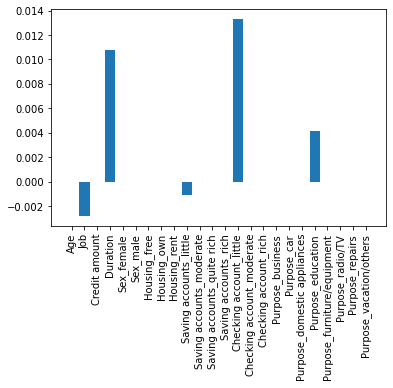

In [351]:
plt.bar(x=X_train.columns, height=r_dtc['importances_mean'])
plt.xticks(rotation=90)
plt.show

### Regresión Logistica

In [352]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)

In [353]:
X_val_scaled = MinMaxScaler().fit_transform(X_val)

In [354]:
model_rl = LogisticRegression()

In [355]:
model_rl.fit(X_train_scaled, y_train)

LogisticRegression()

In [356]:
accuracy_score(y_val, model_rl.predict(X_val_scaled))

0.7333333333333333

In [357]:
r_rl = permutation_importance(model_rl, X_val_scaled, y_val, n_repeats=30)

<function matplotlib.pyplot.show(close=None, block=None)>

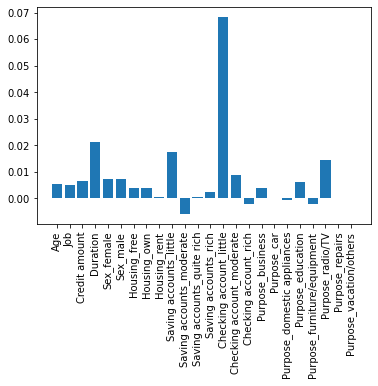

In [358]:
plt.bar(x=X_train.columns, height=r_rl['importances_mean'])
plt.xticks(rotation=90)
plt.show

## Validación Cruzada

In [359]:
from sklearn.model_selection import KFold, StratifiedKFold

In [360]:
X_train = train.drop("Risk", axis=1)
X_train = pd.get_dummies(X_train)
y_train = train["Risk"]

In [361]:
k_fold = KFold(n_splits=3)

In [362]:
r_importances = []

In [363]:
for train_indices, val_indices in k_fold.split(X_train, y_train):
    X_sub_train = X_train.iloc[train_indices, :]
    y_sub_train = y_train.iloc[train_indices]
    X_val =  X_train.iloc[val_indices, :]
    y_val =  y_train.iloc[val_indices]
    
    # Entrenar modelo
    model = DecisionTreeClassifier(max_depth=3)
    model.fit(X_sub_train, y_sub_train)
    print("Result: ", "test_score: ", accuracy_score(y_val, model.predict(X_val)), " - ", "train_score: ", accuracy_score(y_sub_train, model.predict(X_sub_train)))
    
    # Permutacion
    r = permutation_importance(model, X_val, y_val, n_repeats=10)
    r_importances.append(r)
    

Result:  test_score:  0.7393162393162394  -  train_score:  0.7467811158798283
Result:  test_score:  0.6609442060085837  -  train_score:  0.7751605995717344
Result:  test_score:  0.6609442060085837  -  train_score:  0.7687366167023555


In [364]:
cross_validate(DecisionTreeClassifier(max_depth=3), X_train, y_train, cv=3, scoring="accuracy", return_train_score=True)

{'fit_time': array([0.00501704, 0.00278091, 0.0027051 ]),
 'score_time': array([0.0018189 , 0.00167942, 0.00162339]),
 'test_score': array([0.72222222, 0.65236052, 0.71244635]),
 'train_score': array([0.75107296, 0.77944325, 0.74946467])}

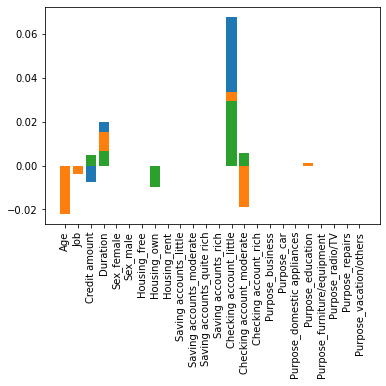

In [365]:
for r in r_importances:    
    plt.bar(x=X_train.columns, height=r['importances_mean'])
    plt.xticks(rotation=90)
    plt.show

In [376]:
r_importances_mean = [r['importances_mean'] for r in r_importances]
r_importances_mean_average = [sum(s)/3 for s in list(zip(*[r for r in r_importances_mean])]
list(r_importances_mean_average)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (6489045.py, line 2)

In [367]:
var = np.zeros(len(r_importances_mean[0]))

In [368]:
for i in range(len(r_importances_mean)):
    var += r_importances_mean[i]

In [369]:
var

array([-0.02274495, -0.00386266, -0.00297128,  0.04154653,  0.        ,
        0.        ,  0.        , -0.00987124,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.13103885, -0.00945857,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00128755,
        0.        ,  0.        ,  0.        ,  0.        ])

In [370]:
promedio = [v/3 for v in var]

In [371]:
promedio

[-0.00758164899795799,
 -0.0012875536480686548,
 -0.0009904258831297235,
 0.013848843891762386,
 0.0,
 0.0,
 0.0,
 -0.0032904148783977037,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.04367961556802761,
 -0.003152855727962992,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0004291845493562319,
 0.0,
 0.0,
 0.0,
 0.0]

<function matplotlib.pyplot.show(close=None, block=None)>

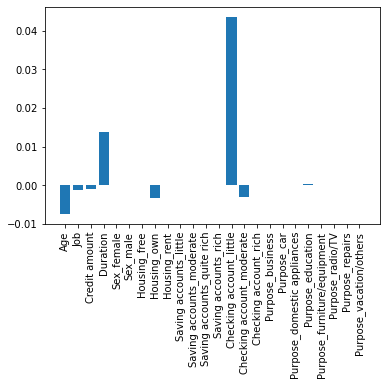

In [374]:
plt.bar(x=X_train.columns, height=promedio)
plt.xticks(rotation=90)
plt.show